In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('Mall_Customers.csv')
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [2]:
print(df.isnull().sum())

X = df[['Annual Income (k$)', 'Spending Score (1-100)']] 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


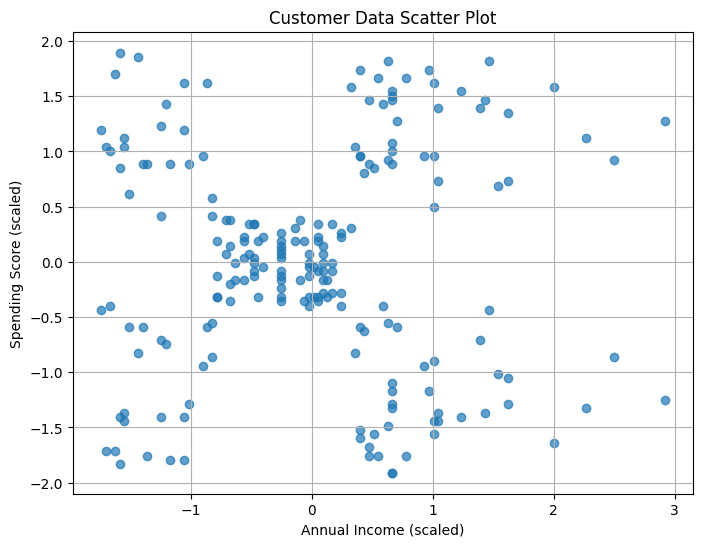

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], marker='o', alpha=0.7)
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.title('Customer Data Scatter Plot')
plt.grid()
plt.show()

In [7]:
from sklearn.metrics import silhouette_score

def fuzzy_c_means(X, k=3, m=2, max_iter=100):
    n = X.shape[0]
    U = np.random.rand(n, k)
    U = U / np.sum(U, axis=1, keepdims=True)
    
    for _ in range(max_iter):
        # Compute centroids
        centroids = []
        for j in range(k):
            numerator = np.sum((U[:, j]**m).reshape(-1, 1) * X, axis=0)
            denominator = np.sum(U[:, j]**m)
            centroid = numerator / denominator
            centroids.append(centroid)
        centroids = np.array(centroids)
        
        # Update membership values
        distances = np.zeros((n, k))
        for j in range(k):
            distances[:, j] = np.linalg.norm(X - centroids[j], axis=1)
        
        new_U = np.zeros((n, k))
        for j in range(k):
            denom = np.sum((distances[:, j].reshape(-1, 1) / distances)**(2/(m-1)), axis=1)
            new_U[:, j] = 1 / denom
        
        if np.allclose(U, new_U, atol=1e-4):
            break
        U = new_U
    
    return U, centroids

best_score = -1
best_k = 2
for k in range(2, 6):
    U, centroids = fuzzy_c_means(X_scaled, k=k)
    labels = np.argmax(U, axis=1)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}, Silhouette Score={score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nOptimal number of clusters: {best_k}")

k=2, Silhouette Score=0.3292
k=3, Silhouette Score=0.4641
k=4, Silhouette Score=0.4939
k=5, Silhouette Score=0.5547

Optimal number of clusters: 5



Cluster Centroids (Annual Income, Spending Score):
[[86.13047655 16.70336675]
 [26.45809762 77.89577502]
 [56.21660502 49.57606487]
 [27.05888315 18.49230747]
 [84.41675995 82.80068653]]


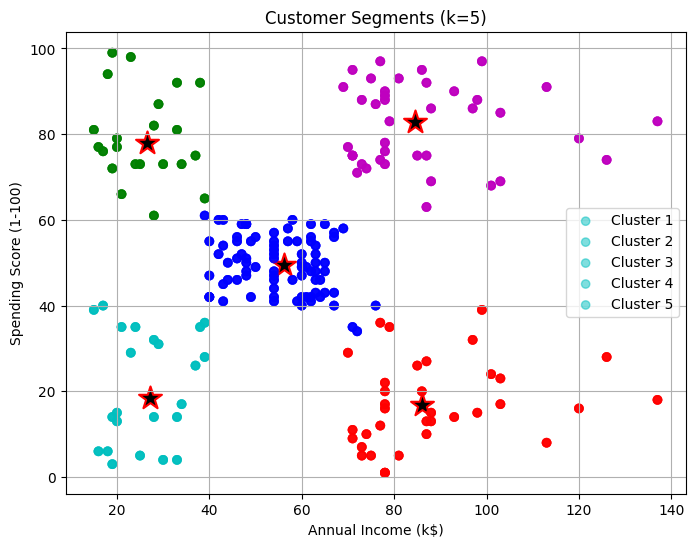

In [8]:
U, centroids = fuzzy_c_means(X_scaled, k=best_k)
labels = np.argmax(U, axis=1)

centroids_original = scaler.inverse_transform(centroids)
print("\nCluster Centroids (Annual Income, Spending Score):")
print(centroids_original)

plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm']
for i in range(best_k):
    plt.scatter(X['Annual Income (k$)'], X['Spending Score (1-100)'], 
                c=[colors[l] for l in labels], 
                alpha=0.5, 
                label=f'Cluster {i+1}')
    plt.scatter(centroids_original[i, 0], centroids_original[i, 1], 
                marker='*', s=300, c='black', 
                edgecolors='red', linewidths=1.5)

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title(f'Customer Segments (k={best_k})')
plt.legend()
plt.grid()
plt.show()


Performance Metrics for Different Cluster Counts:
k     Partition Coefficient Classification Entropy
2     0.6970               0.4634              
3     0.6802               0.5781              
4     0.6633               0.6692              
5     0.6711               0.7037              

Best Partition Coefficient: k = 2 with PC = 0.697
Best Classification Entropy: k = 2 with CE = 0.4634


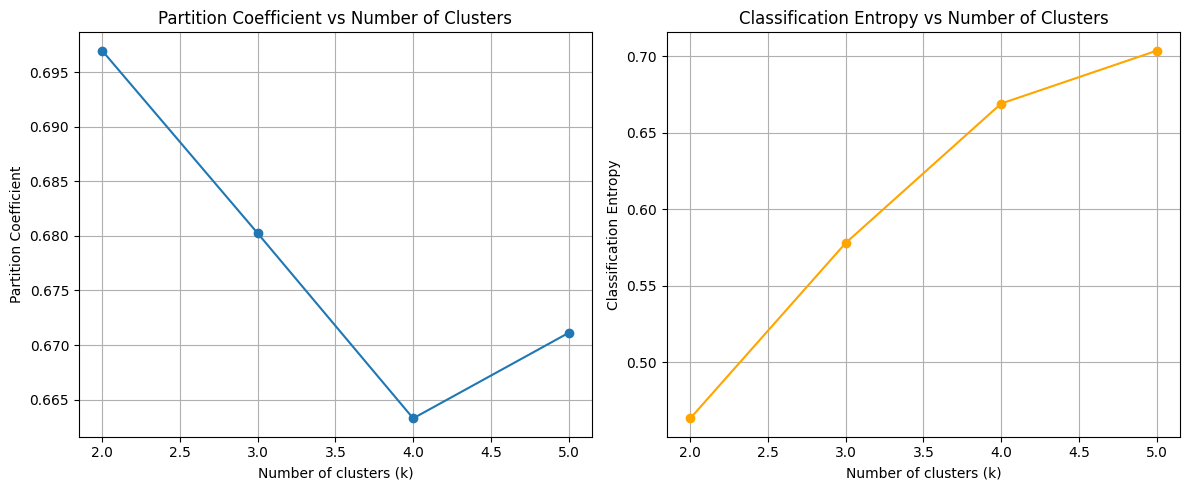

In [10]:

def partition_coefficient(U):
    return np.sum(U**2) / len(U)

def classification_entropy(U):
    return -np.sum(U * np.log(U + 1e-10)) / len(U)  

print("\nPerformance Metrics for Different Cluster Counts:")
print("{:<5} {:<20} {:<20}".format('k', 'Partition Coefficient', 'Classification Entropy'))

for k in range(2, 6):
    U, centroids = fuzzy_c_means(X_scaled, k=k)
    
    pc = partition_coefficient(U)
    ce = classification_entropy(U)
    
    print("{:<5} {:<20.4f} {:<20.4f}".format(k, pc, ce))

    if k == 2:
        best_pc = pc
        best_ce = ce
        best_k_pc = k
        best_k_ce = k
    else:
        if pc > best_pc:
            best_pc = pc
            best_k_pc = k
        if ce < best_ce:
            best_ce = ce
            best_k_ce = k

print("\nBest Partition Coefficient: k =", best_k_pc, "with PC =", round(best_pc, 4))
print("Best Classification Entropy: k =", best_k_ce, "with CE =", round(best_ce, 4))

k_values = range(2, 6)
pc_values = []
ce_values = []

for k in k_values:
    U, _ = fuzzy_c_means(X_scaled, k=k)
    pc_values.append(partition_coefficient(U))
    ce_values.append(classification_entropy(U))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, pc_values, marker='o')
plt.title('Partition Coefficient vs Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Partition Coefficient')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(k_values, ce_values, marker='o', color='orange')
plt.title('Classification Entropy vs Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Classification Entropy')
plt.grid()

plt.tight_layout()
plt.show()


k=2
Partition Coefficient: 0.6969
Classification Entropy: 0.4635


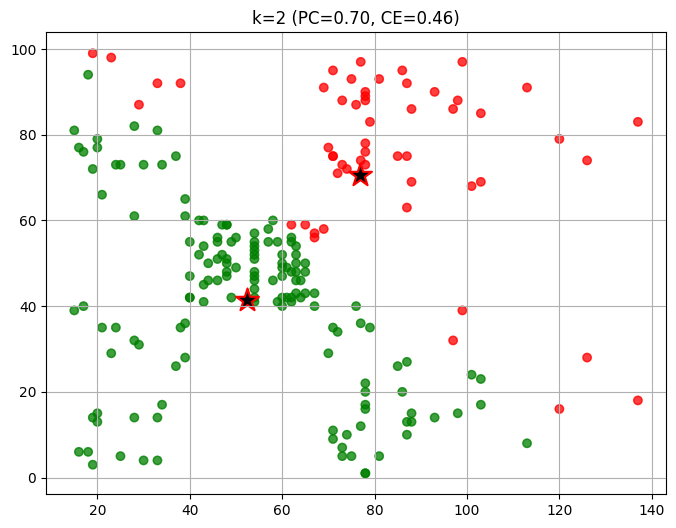


k=3
Partition Coefficient: 0.6802
Classification Entropy: 0.5781


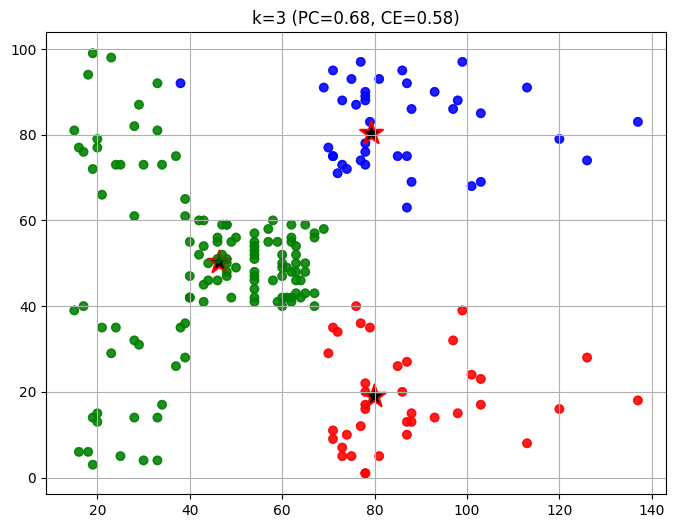


k=4
Partition Coefficient: 0.6633
Classification Entropy: 0.6692


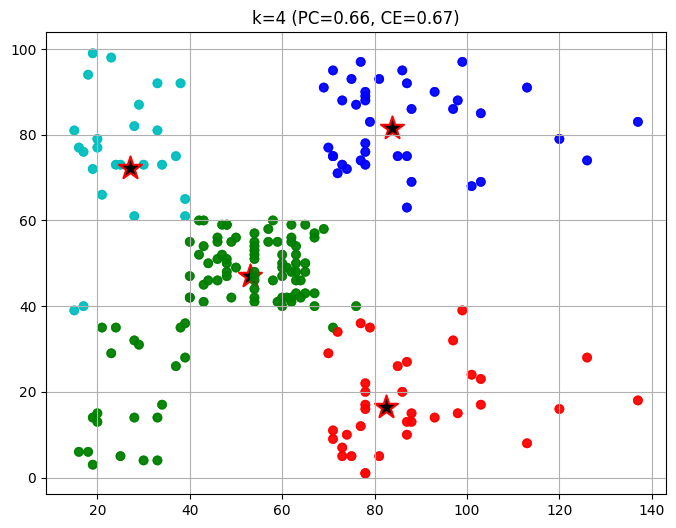


k=5
Partition Coefficient: 0.6711
Classification Entropy: 0.7037


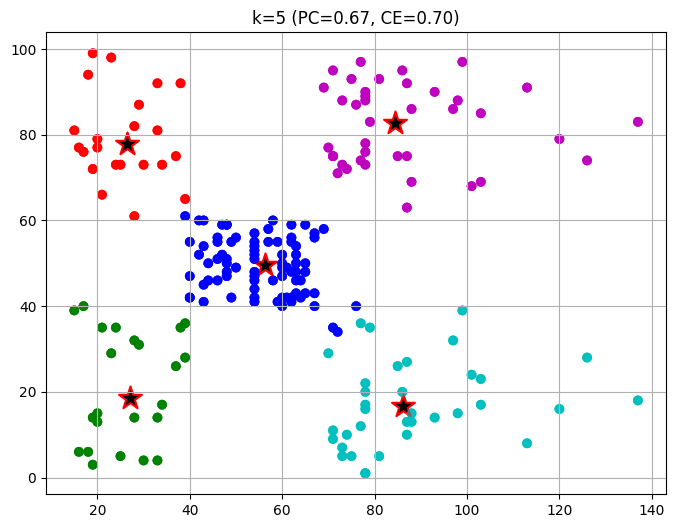

In [9]:
def partition_coefficient(U):
    return np.sum(U**2) / len(U)

def classification_entropy(U):
    return -np.sum(U * np.log(U + 1e-10)) / len(U)

for k in range(2, 6):
    U, centroids = fuzzy_c_means(X_scaled, k=k)
    labels = np.argmax(U, axis=1)
    
    pc = partition_coefficient(U)
    ce = classification_entropy(U)
    
    print(f"\nk={k}")
    print(f"Partition Coefficient: {pc:.4f}")
    print(f"Classification Entropy: {ce:.4f}")
    
    plt.figure(figsize=(8, 6))
    centroids_original = scaler.inverse_transform(centroids)
    for i in range(k):
        plt.scatter(X['Annual Income (k$)'], X['Spending Score (1-100)'], 
                    c=[colors[l] for l in labels], 
                    alpha=0.5)
        plt.scatter(centroids_original[i, 0], centroids_original[i, 1], 
                    marker='*', s=300, c='black', 
                    edgecolors='red', linewidths=1.5)
    plt.title(f'k={k} (PC={pc:.2f}, CE={ce:.2f})')
    plt.grid()
    plt.show()